# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых. У нас в распоряжении исторические данные о поведении клиентов и расторжении договоров с банком.

**Цель проекта.**
Целью проекта является необходимость спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Другими словами требуется построить модель, предсказывающую возможное прекращение сотрудничества клиента с банком.

**План работ.**
1. Загрузка данных.
2. Предобработка данных.
3. Исследовательский анализ.
4. Подготовка данных и обучение моделей.
5. Итоговое тестирование.
6. Вывод.

**Описание данных.**

Признаки
- `RowNumber` — индекс строки в данных;
- `CustomerId` — уникальный идентификатор клиента;
- `Surname` — фамилия;
- `CreditScore` — кредитный рейтинг;
- `Geography` — страна проживания;
- `Gender` — пол;
- `Age` — возраст;
- `Tenure` — сколько лет человек является клиентом банка;
- `Balance` — баланс на счёте;
- `NumOfProducts` — количество продуктов банка, используемых клиентом;
- `HasCrCard` — наличие кредитной карты;
- `IsActiveMember` — активность клиента;
- `EstimatedSalary` — предполагаемая зарплата.

Целевой признак
- `Exited` — факт ухода клиента.

## 1. Загрузка данных

Импортируем необходимые библиотеки

In [1]:
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, roc_auc_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

In [2]:
# анализ категориальных признаков
def analysis_cat(feature, x_label, y_label, title):
    one = data[data['Exited']==1].pivot_table(index=feature, values='Balance', aggfunc='count')
    zero = data[data['Exited']==0].pivot_table(index=feature, values='Balance', aggfunc='count')
    table = zero.merge(one, how='left', on=feature)
    table.columns = ['NotLeft', 'Left']
    table.plot(kind='bar', stacked= True, figsize=(10,6))
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.show()
    
# анализ количественных признаков
def analysis_num(feature, x_label, y_label, title):
    minim = data.pivot_table(index='Exited', values=feature, aggfunc='min')
    maxim = data.pivot_table(index='Exited', values=feature, aggfunc='max')
    avg = data.pivot_table(index='Exited', values=feature, aggfunc='mean')
    table = minim.merge(maxim, how='left', on='Exited').merge(avg, how='left', on='Exited')
    table.columns = ['Min', 'Max', 'Mean']
    table.plot(kind='bar', figsize=(10,6), grid=True)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.show()

In [3]:
RANDOM_STATE = 0

In [4]:
warnings.filterwarnings('ignore')

Посмотрим на размер исходного датасета и первые его строки

In [5]:
data = pd.read_csv('Churn.csv')
data.shape

(10000, 14)

In [6]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Приведем общую информацию о признаках данных

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


**ИТОГ.**
В ходе первого этапа проекта загрузили данные и посмотрели на их структуру.

## 2. Предобработка данных

Проверим, есть ли пропуски в данных

In [8]:
pd.DataFrame(data.isna().sum() / data.shape[0] * 100, columns=['pass']).style.background_gradient('coolwarm')

,pass
RowNumber,0.000000
CustomerId,0.000000
Surname,0.000000
CreditScore,0.000000
Geography,0.000000
Gender,0.000000
Age,0.000000
Tenure,9.090000
Balance,0.000000
NumOfProducts,0.000000


9% данных в столбце `Tenure` пропущено. Посмотрим, можно ли по другим признакам заполнить пропуски.

In [9]:
data.corr().style.background_gradient('coolwarm')

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,1.000000,0.004202,0.005840,0.000783,-0.007322,-0.009067,0.007246,0.000599,0.012044,-0.005988,-0.016571
CustomerId,0.004202,1.000000,0.005308,0.009497,-0.021418,-0.012419,0.016972,-0.014025,0.001665,0.015271,-0.006248
CreditScore,0.005840,0.005308,1.000000,-0.003965,-0.000062,0.006268,0.012238,-0.005458,0.025651,-0.001384,-0.027094
Age,0.000783,0.009497,-0.003965,1.000000,-0.013134,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.285323
Tenure,-0.007322,-0.021418,-0.000062,-0.013134,1.000000,-0.007911,0.011979,0.027232,-0.032178,0.010520,-0.016761
Balance,-0.009067,-0.012419,0.006268,0.028308,-0.007911,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.118533
NumOfProducts,0.007246,0.016972,0.012238,-0.030680,0.011979,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.047820
HasCrCard,0.000599,-0.014025,-0.005458,-0.011721,0.027232,-0.014858,0.003183,1.000000,-0.011866,-0.009933,-0.007138
IsActiveMember,0.012044,0.001665,0.025651,0.085472,-0.032178,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.156128
EstimatedSalary,-0.005988,0.015271,-0.001384,-0.007201,0.010520,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.012097


Как видим признак `Tenure` ни с каким другим признаком не коррелирует. Придется удалить пропуски в этом столбце. Кроме этого удалим неинформативные признаки `RowNumber`, `CustomerId`, `Surname`. 

In [10]:
data = data.dropna()

Проверим данные на дубликаты

In [11]:
print('Количество дубликатов в данных:', data.duplicated().sum())

Количество дубликатов в данных: 0


Удалим неинформативные признаки

In [12]:
data = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1).reset_index(drop=True)
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


**ИТОГ.**
В ходе предобработки данных было сделано следующее:
- обработаны пропуски в данных;
- данные исследованы на дубликаты;
- удалены неинформативные признаки.

## 3. Исследовательский анализ данных

Посмотрим, как распределяется число ущедших и неушедших клиентов по странам

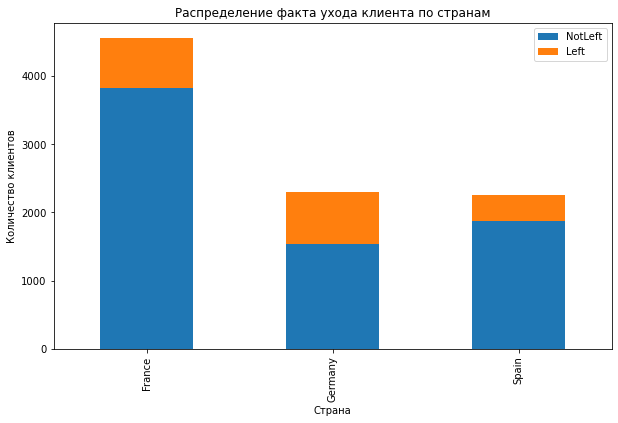

In [13]:
analysis_cat('Geography', 'Страна', 'Количество клиентов', 'Распределение факта ухода клиента по странам')

Большинство клиентов банка находится во Франции (их более 4000). В Германии и Испании число клиентов примерно одинаковое, но в Германии более значительная доля ушедших клиентов (примерно 1/3). Посмотрим как влияет гендер клиента на факт ухода

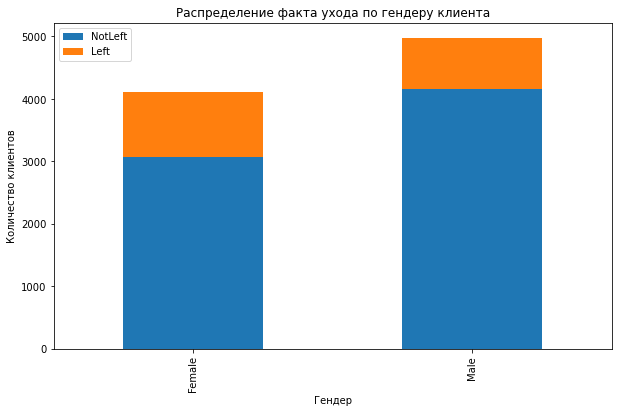

In [14]:
analysis_cat('Gender', 'Гендер', 'Количество клиентов', 'Распределение факта ухода по гендеру клиента')

Среди клиентов больше мужчин, но доля тех, кто ушел больше у женщин. Теперь посмотрим на доли ушедших клиентов в зависимости от наличия у них кредитной карты.

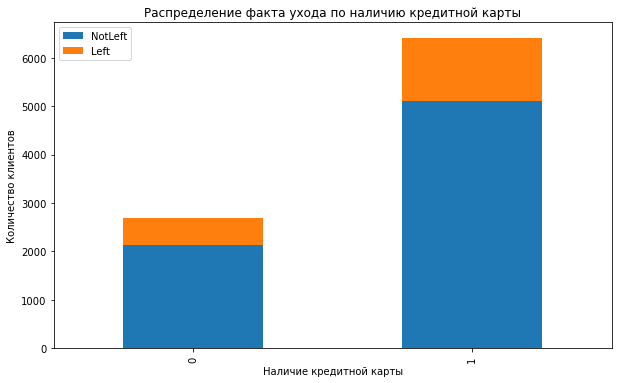

In [15]:
analysis_cat('HasCrCard', 'Наличие кредитной карты', 
             'Количество клиентов', 
             'Распределение факта ухода по наличию кредитной карты')

Большинство клиентов имеют кредитную карту. При этом доля ушедших клиентов также значительно больше среди тех, у кого в наличии есть кредитная карта. Проанализируем кредитный рейтинг клиентов.

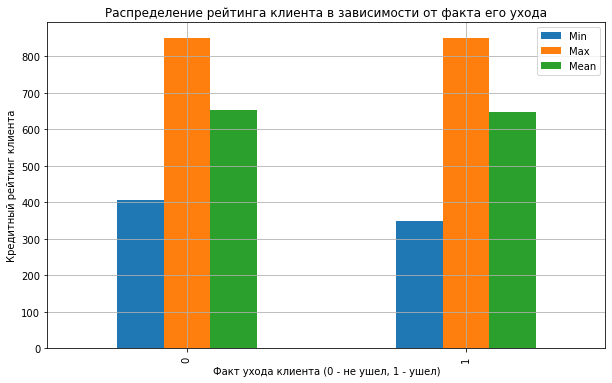

In [16]:
analysis_num('CreditScore', 
             'Факт ухода клиента (0 - не ушел, 1 - ушел)', 
             'Кредитный рейтинг клиента', 
             'Распределение рейтинга клиента в зависимости от факта его ухода')

Уровень максимального и среднего кредитного рейтинга киентов в двух категориях примерно одинаковый. Минимальное значение рейтинга немного отличается (около 400 у тех клиентов, которые не ушли, и примерно 350 у ушедших клиентов). Взглянем на распределение возраста клиентов.

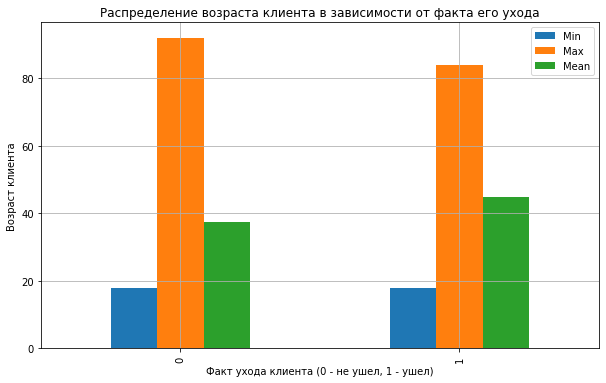

In [17]:
analysis_num('Age', 
             'Факт ухода клиента (0 - не ушел, 1 - ушел)', 
             'Возраст клиента', 
             'Распределение возраста клиента в зависимости от факта его ухода')

Стоит отметить, что уровень среднего возраста больше у прекративших сотрудничество с банком клиентов.

**ИТОГ.**
В ходе исследовательского анализа данных проанализировали зависимость целевого признака (факт ухода клиента) от некоторых категориальных (страна проживания, гендер, наличие кредитной карты) и количественных (кредитный рейтинг клиента и возраст клиента) признаков.

## 4. Подготовка данных и обучение моделей

Проверим данные на дисбаланс классов целевого признака.

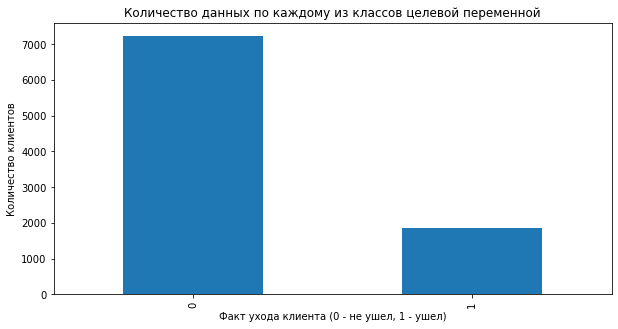

In [18]:
data['Exited'].value_counts().plot(kind='bar', figsize=(10,5))
plt.xlabel('Факт ухода клиента (0 - не ушел, 1 - ушел)')
plt.ylabel('Количество клиентов')
plt.title('Количество данных по каждому из классов целевой переменной')
plt.show()

Заметен явный дисбаланс классов. При обучении моделей будем использовать метод взвешенных классов для борьбы с дисбалансом. Разделим данные на обучающую и тестовую выборки.

In [19]:
train, test = train_test_split(data, test_size=0.25, random_state=RANDOM_STATE, stratify=data['Exited'])
features_train = train.drop('Exited', axis=1)
features_test = test.drop('Exited', axis=1)
target_train = train['Exited'] 
target_test = test['Exited']

In [20]:
print(train.shape, test.shape)

(6818, 11) (2273, 11)


Сделаем из признаков `HasCrCard` и `IsActiveMember` категориалные

In [21]:
data['HasCrCard'] = data['HasCrCard'].astype('str')
data['IsActiveMember'] = data['IsActiveMember'].astype('str')

Определим набор категориальных и количественных признаков

In [22]:
cat = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']
num = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

Приступим к обучению различных моделей. Начнем с дерева решений.

In [23]:
transformer_features = make_column_transformer((OneHotEncoder(drop='first', sparse=False), cat),
                                               (StandardScaler(), num))
pipe = Pipeline([
    ('preproc', transformer_features),
    ('model', DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced'))
])

param = {'model__max_depth':range(1,30),
         'model__min_samples_split':range(0, 4), 
         'model__min_samples_leaf':range(0,4)}

grid_dec = RandomizedSearchCV(pipe, param, cv=5, scoring='f1', n_iter=200, random_state=RANDOM_STATE)
grid_dec.fit(features_train, target_train)
dec_score = grid_dec.best_score_
print('Параметры наилучшей модели:', grid_dec.best_params_)
print('Значение метрики F1:', dec_score)

Параметры наилучшей модели: {'model__min_samples_split': 2, 'model__min_samples_leaf': 2, 'model__max_depth': 6}
Значение метрики F1: 0.5674319793565411


Обучим случайный лес

In [24]:
transformer_features = make_column_transformer((OneHotEncoder(drop='first', sparse=False), cat),
                                               (StandardScaler(), num))
pipe = Pipeline([
    ('preproc', transformer_features),
    ('model', RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced'))
])

param_grid = {'model__n_estimators':range(1, 200, 10),
              'model__max_depth':range(1, 20),
              'model__min_samples_split':range(0, 4), 
              'model__min_samples_leaf':range(0,4)}

grid_forest = RandomizedSearchCV(pipe, param_grid, cv=5, scoring='f1', n_iter=200, random_state=RANDOM_STATE)
grid_forest.fit(features_train, target_train)
forest_score = grid_forest.best_score_
print('Параметры наилучшей модели:', grid_forest.best_params_)
print('Значение метрики F1:', forest_score)

Параметры наилучшей модели: {'model__n_estimators': 181, 'model__min_samples_split': 2, 'model__min_samples_leaf': 3, 'model__max_depth': 9}
Значение метрики F1: 0.6129003585163136


Посмотрим на обучение логистической регрессии

In [25]:
transformer_features = make_column_transformer((OneHotEncoder(drop='first', sparse=False), cat),
                                               (StandardScaler(), num))
pipe = Pipeline([
    ('preproc', transformer_features),
    ('model', LogisticRegression(random_state=RANDOM_STATE))
])

param_grid = {'model__penalty':[None, 'l2', 'l1', 'elasticnet'],
              'model__C':[0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}

grid_log = RandomizedSearchCV(pipe, param_grid, cv=5, scoring='f1', n_iter=200, random_state=RANDOM_STATE)
grid_log.fit(features_train, target_train)
log_score = grid_log.best_score_
print('Параметры наилучшей модели:', grid_log.best_params_)
print('Значение метрики F1:', log_score)

Параметры наилучшей модели: {'model__penalty': 'l2', 'model__C': 10}
Значение метрики F1: 0.29800355062482836


Сравним результаты тестирования трех моделей.

In [26]:
table = pd.DataFrame([['DecisionTreeClassifier', dec_score],
                      ['RandomForestClassifier', forest_score],
                      ['LogisticRegression', log_score]], columns=['Name', 'F1_score'])
table

,Name,F1_score
0,DecisionTreeClassifier,0.567432
1,RandomForestClassifier,0.612900
2,LogisticRegression,0.298004


**ИТОГ.**
В ходе данного этапа данные были разбиты на тренировочную и тестовую выборки. Также было проведено тестирование трех моделей: дерева решений, случайного леса и логистической регрессии. Наилучший показатель метрики F1 показала модель случайного леса (0.613). Данная модель будет выбрана для итогового тестирования.

## 5. Итоговое тестирование

Протестируем модель на тестовом наборе данных.

In [27]:
transformer_features = make_column_transformer((OneHotEncoder(drop='first', sparse=False), cat),
                                               (StandardScaler(), num))
pipe_test = Pipeline([
    ('preproc', transformer_features),
    ('model', RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced', 
                                     n_estimators=181, max_depth=9, min_samples_split=2, 
                                     min_samples_leaf=3))
])

pipe_test.fit(features_train, target_train)
predict = pipe_test.predict(features_test)
prob = pipe_test.predict_proba(features_test)
probabilities = prob[:,1]
f1 = f1_score(target_test, predict)
precision = precision_score(target_test, predict)
recall = recall_score(target_test, predict)
table = pd.DataFrame([[f1, precision, recall]], columns=['f1', 'precision', 'recall'])
table

,f1,precision,recall
0,0.639053,0.589091,0.698276


Видим, что выбранная модель показала метрику F1, равную 0.64. При этом стоит отметить, что модель неплохо находит тех клиентов, которые хотят уйти (об этом говорит метрика recall, равная почти 0.7). Наши выводы также подтверждает матрица ошибок.

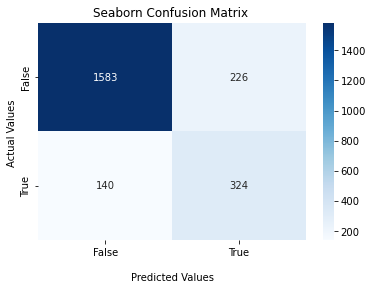

In [28]:
ax = sns.heatmap(confusion_matrix(target_test, predict), annot=True, cmap='Blues', fmt='')

ax.set_title('Seaborn Confusion Matrix ');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

plt.show()

Мосмотрим также на метрику ROC-AUC

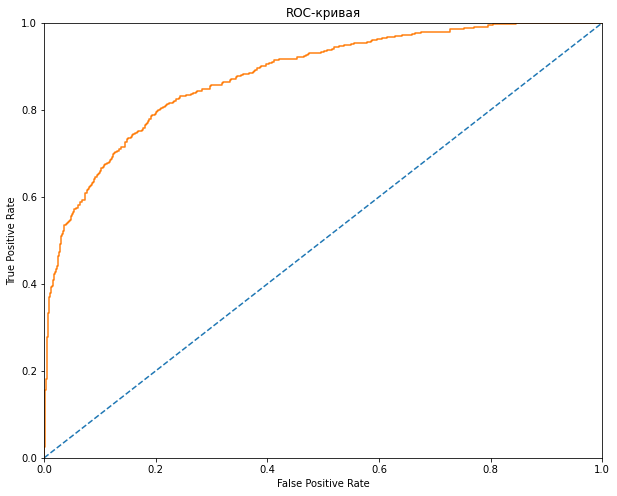

In [29]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities)
plt.figure(figsize=(10,8))
plt.plot([0,1], [0,1], linestyle='--')
plt.plot(fpr, tpr, linestyle='-')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

In [30]:
print('Метрика AUC-ROC:', roc_auc_score(target_test, probabilities))

Метрика AUC-ROC: 0.8780320142582108


In [31]:
print('Метрика Accuracy:', accuracy_score(target_test, predict))

Метрика Accuracy: 0.8389793224813022


**ИТОГ.**
В ходе последнего этапа исследования мы протестировали выбранную раньше модель на тестовом наборе данных. Также привели рассчеты различных метрик модели.

## 6. Вывод

По ходу нашего проекта мы выполнили несколько важных этапов: 
- на предобработке данных мы удалили пропуски в признаке `Tenure`, проверили данные на дубликаты, а также убрали неинформативные признаки;
- на этапе исследовательского анализа данных проанализировали зависимость целевого признака `Exited` от некоторых категориальных признаков (`Geography`, `Gender`, `HasCrCard`) и количественных признаков (`CreditScore` и `Age`);
- в ходе подготовки данных и обучения моделей данные были исследованы на дисбаланс классов в целевом признаке (объем данных о клиентах, которые не ушли из банка, значительно превышает данные об ушедших клиентах), а также были обучены 3 модели (дерево решений, случайный лес, логистическая регрессия) и из них была выбрана наилучшая для итогового тестирования, а именно случайный лес (метрика f1 равна 0.61);
- на этапе итогового тестирования была обучена модель случайного леса с параметрами random_state=RANDOM_STATE, class_weight='balanced', n_estimators=181, max_depth=9, min_samples_split=2, min_samples_leaf=3. На тестовой выборке данная модель предсказала правильно почти 84% ответов, метрика recall достигает уровня почти в 0.7 